In [17]:
import netCDF4 as nc
import pylab as py
import numpy as np
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.cm as cm
import sys
import os
import errno


import hickle as hkl

## A function to save a dictionary ##
def save(filename,dictionary):
    hkl.dump(dictionary, filename, mode='w')
    
## A function to load a dictionary ## 
def load(filename):
    dictionary = hkl.load(filename)
    return dictionary

def make_sure_path_exists(path):
    try:
        os.makedirs(path)
        logging.debug('destination folder created !')
    except OSError as exception:
        if exception.errno != errno.EEXIST:
            logging.debug('destination folder exists already!')
            raise

####################
#### soomthening ###
####################

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth            

dirc=np.array([0,str('aqua'),str('isca5m')])
num=1 ## represents an annual year of data
#source='/project2/tas1/pragallvaring_quarter_2018/post_process_data/'+dirc[1]+'_'+dirc[2]+str(i)+'/'

#source1='/project2/tas1/pragallva/Spring_quarter_2018/exp_data/'+dirc[1]+'_'+dirc[2]+'/'
source1='/project/tas1/pragallva/Fall_quarter_2017/Isca/input/'
one_year='sst_field'+'.nc'
ncfile=source1+one_year
lat=nc.Dataset(ncfile,'r').variables['lat'][:]
var=nc.Dataset(ncfile,'r')

lat=var.variables['lat'][:]
lon=var.variables['lon'][:]
sst=var.variables['sst_clim_amip'][:]
zon_sst=var.variables['zon_symmetric_sst'][:]


In [18]:
zon_sst.shape

(12, 180, 360)

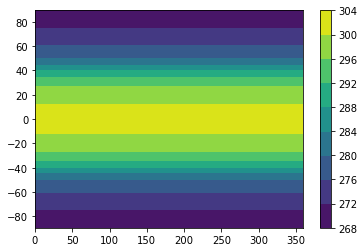

In [22]:
py.contourf(lon, lat, zon_sst.mean(axis=0)); py.colorbar()
py.show()

In [15]:
def N_S_avg(X,flux_flag=-1):
    l_N=((lat>-0.1) & (lat<=90))            
    l_S=((lat>=-90) & (lat<=0))    
    avg = lambda x: (x[l_N]+flux_flag*(x[l_S][::-1]))/2.0
    X= avg(X)
    #return X
    a= lambda x: np.append(X[::-1],X)
    return a(X)
    

In [5]:
sst.shape

(12, 180, 360)

In [3]:
zon_sst=sst.mean(axis=-1).mean(axis=0)
symmetric_sst=N_S_avg(zon_sst,1)

In [4]:
symmetric_sst.shape

(180,)

In [12]:
zonal_sst      = np.dstack([symmetric_sst]*360).transpose(1,2,0)
time_sst       = np.dstack([zonal_sst]*12).transpose(2,0,1)

In [13]:
time_sst.shape

(12, 180, 360)

[[Model]]
    Model(gaussian)
[[Fit Statistics]]
    # function evals   = 34
    # data points      = 180
    # variables        = 3
    chi-square         = 434.054
    reduced chi-square = 2.452
[[Variables]]
    sigma:       32.6990731 +/- 0.303066 (0.93%) (init= 41.5)
    fwhm:        77.0004313 +/- 0.713667 (0.93%)  == '2.3548200*sigma'
    center:     -0.00011860 +/- 0.301686 (254364.17%) (init= 0)
    amplitude:   2589.40481 +/- 20.70598 (0.80%) (init= 2431.63)
[[Correlations]] (unreported correlations are <  1.000)



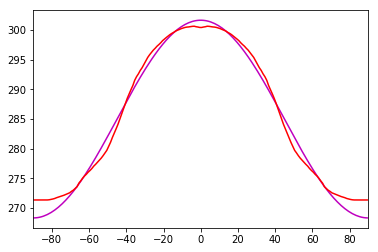

In [539]:
def gauss_func(A,sigma,mu,x=lat,d=np.min(symmetric_sst)):
    y=(A/(sigma*np.sqrt(2*np.pi)))*np.exp(-(x-mu)**2/(2*sigma**2))+d
    return y


delta_T=50.0
tconst=285.0
temp_dist=tconst - delta_T*((2.*np.sin(np.radians(lat))**2.)-1.)/3.
py.plot(x,  temp_dist,'m-')

from lmfit.models import  GaussianModel
mod = GaussianModel()

x = lat
y = symmetric_sst-np.min(symmetric_sst)
pars = mod.guess(y, x=x)
out = mod.fit(y, pars, x=x)
print(out.fit_report(min_correl=1))

sigma=out.best_values['sigma']
mu=out.best_values['center']
A=out.best_values['amplitude']


py.plot(x,y+np.min(symmetric_sst),'r-')
# py.plot(x,out.best_fit+np.min(symmetric_sst),'b-')
# py.plot(x,  gauss_func(A*1.8,sigma,mu),'g-')
# py.plot(x,  gauss_func(A*1.8,sigma*1.8,mu),'m-')
py.xlim(-90,90)
py.show()



{'amplitude': 2589.4048192791415,
 'center': -0.0001186042114218845,
 'sigma': 32.699073126664615}

In [482]:
sigma=pars['sigma'].value
mu=pars['center'].value
A=amp=pars['amplitude'].value

In [485]:
A/(sigma*np.sqrt(2*np.pi))+np.min(e_sst)

294.7336726938631

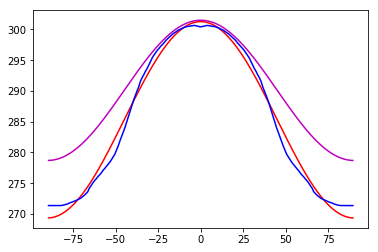

In [561]:
import numpy as np
from scipy.optimize import curve_fit
def func(x, tconst, delta_T, A,divide):
    return tconst - delta_T*((A*np.sin(np.radians(lat))**2.)-1.)/np.float(divide)

N=len(lat)
sigma =np.ones(N)
# sigma[[0,1,2,3,4,5,6,7,8,9,10,15, 20,25,30, (N/30), N/20 , N/5, (N/4), (N/3), N/2-50, N/2-5, N/2-10, N/2-1, (N/2),N/2+1, N/2+5,  N/2+10,  N/2+50, int(2*N/3),int(3*N/4),4*N/5,int(19*N/20.0),int(29*N/30.0),-31,-26,-21,-16, -11,-10,-9,-8,-7,-6,-5,-4, -3,-2,-1]] = 0.01
# sigma[[0, (N/2),-1]] = 0.00001
xdata=lat
ydata=symmetric_sst
popt, pcov = curve_fit(func, xdata, ydata, sigma=sigma)
popt

py.plot(xdata, func(xdata, *popt), 'r-')
py.plot(lat, symmetric_sst, 'b-')
tconst, delta_T, A,divide=popt
py.plot(xdata, func(xdata, tconst, delta_T, A,divide*1.4), 'm-')
py.show()


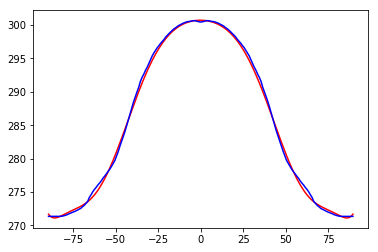

In [332]:
import numpy as np
from scipy.optimize import curve_fit
def func(x, a, b, c, d, e,f, g, h,i,j,k,l):
    return a + b * x + c * x ** 2 + d * x ** 3 + e*x**4 + f*x**5 + g*x**6 + h*x**7  + i*x**8 + j*x**9+k*x**10 +l*x**11 #+ m*x**12 + n*x**13+ o*x**14

N=len(lat)
sigma =np.ones(N)
sigma[[0,1,2,3,4,5,6,7,8,9,10,15, 20,25,30, (N/30), N/20 , N/5, (N/4), (N/3), N/2-50, N/2-5, N/2-10, N/2-1, (N/2),N/2+1, N/2+5,  N/2+10,  N/2+50, int(2*N/3),int(3*N/4),4*N/5,int(19*N/20.0),int(29*N/30.0),-31,-26,-21,-16, -11,-10,-9,-8,-7,-6,-5,-4, -3,-2,-1]] = 0.01
#sigma[[0,int(N/20.0), (N/4), int(N/3.0), (N/2), 2*N/3,int(3*N/4), int(19*N/20.0),-1]] = 0.00001
xdata=lat
ydata=symmetric_sst
popt, pcov = curve_fit(func, xdata, ydata, sigma=sigma)
popt

py.plot(xdata, func(xdata, *popt), 'r-')
py.plot(lat, symmetric_sst, 'b-')
py.show()



In [337]:
a,b,c,d,e,f,g,h,i,j,k,l=popt[:]
x=(lat)
y=b + 2*c*x**1+ 3*d*x**2 + 4*e*x**3  + 5*f*x**4 + 6*g*x**5 + 7*h*x**6 + 8*i*x**7 + 9*j*x**8 + 10*k*x**9 + 11*l*x**10 

In [344]:
R=6371e3
def spher_div(x,fac=1):
       dtheta=(lat[1]-lat[0])
       N=10
#        fac=1 #np.cos(np.radians(lat))
       div=np.copy(x)
       #div= smooth( np.gradient((x)*(fac),dtheta)/( R*np.cos(np.radians(lat[:])) ),N)
       div= smooth( np.gradient((x)*(fac),dtheta)/( R),N)
       return div

In [345]:
dTdphi=spher_div(symmetric_sst)

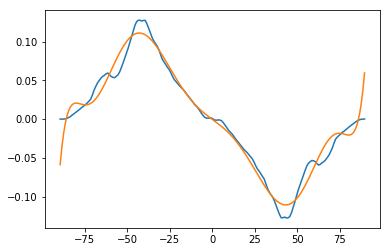

In [357]:
# py.plot(lat,zon_sst,'-')
# py.plot(lat,symmetric_sst,'-')

# py.plot(lat, symmetric_sst-symmetric_sst.mean(), 'r-')
py.plot(lat,dTdphi*1000000,'-')
py.plot(lat,1000000*y/R,'-')
py.show()